In [2]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(299),
        # transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(299),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

train = torchvision.datasets.ImageFolder(
    root = 'TrafficLights/train/',
    transform = data_transforms['train']
)


train_loader = torch.utils.data.DataLoader(
    train, 
    batch_size= 4,
    shuffle=True
)

val = torchvision.datasets.ImageFolder(
    root = 'TrafficLights/val/',
    transform = data_transforms['val']
)


val_loader = torch.utils.data.DataLoader(
    val, 
    batch_size= 4,
    shuffle=True
)

In [4]:
from torchvision.models import inception_v3
# Use this model parameters if your torch version is 1.11 - My version
model = models.inception_v3(pretrained=True)
model.aux_logits=False
model

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

In [5]:

num_ftrs = model.fc.in_features
# print(num_ftrs)
# Here the size of each output sample is set to 2. In your model use nn.Linear(num_ftrs, len(class_names)) to generalize to your number of classes.
model.fc = nn.Linear(num_ftrs, 9)

# model_ft = model.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [6]:
from datetime import datetime
import tqdm as tqdm

EPOCHS = 50  # 50

train_loss = [np.nan]
train_accuracy = [np.nan]
test_loss = [np.nan]

model.train()

pbar = tqdm.tqdm(total=EPOCHS, position=0, leave=True)
pbar.set_description("EPOCH 1: Training Loss: NA, ")


for epoch in range(EPOCHS):
  total, correct, running_loss = 0, 0, 0

  for batch_idx, (data, target) in enumerate(train_loader):
    model.train()
    # if cuda:
    #   data, target = data.cuda(), target.cuda()
    
    optimizer_ft.zero_grad()

    out = model(data)

    loss = criterion(out, target)
    loss.backward()
    optimizer_ft.step()

    current_loss = loss.cpu().data.item()
    running_loss += current_loss

    _, predicted = out.max(1)
    total += target.size(0)
    correct += predicted.eq(target).sum().cpu().item()

    pbar.set_description(f"EPOCH {epoch+1}\t Batch Loss: {current_loss:.3f}\t  Epoch Loss: {train_loss[-1]:.3f}\t Train Acc: {train_accuracy[-1]:.3f}\t Test Loss: {test_loss[-1]:.3f}\t")

  test_running_loss = 0
  model.eval()

  with torch.no_grad():
    for batch_idx, (data, target) in enumerate(val_loader):
      # if cuda:
      #   data, target = data.cuda(), target.cuda()

      out = model(data)

      loss = criterion(out, target)

      test_running_loss += loss.cpu().data.item()

    LTest = test_running_loss/len(val_loader)

  LTrain = running_loss/len(train_loader)
  accu = 100.*correct/total

  train_accuracy.append(accu)
  train_loss.append(LTrain)
  test_loss.append(LTest)

  pbar.set_description(
      f"EPOCH {epoch+1}\t Batch Loss: {current_loss:.3f}\t  Epoch Loss: {train_loss[-1]:.3f}\t Train Acc: {train_accuracy[-1]:.3f}\t Test Loss: {test_loss[-1]:.3f}\t")

  pbar.update()

del train_accuracy[0]
del train_loss[0]
del test_loss[0]

EPOCH 50	 Batch Loss: 0.114	  Epoch Loss: 0.704	 Train Acc: 75.899	 Test Loss: 0.859	: 100%|██████████| 50/50 [10:45:35<00:00, 657.81s/it]   

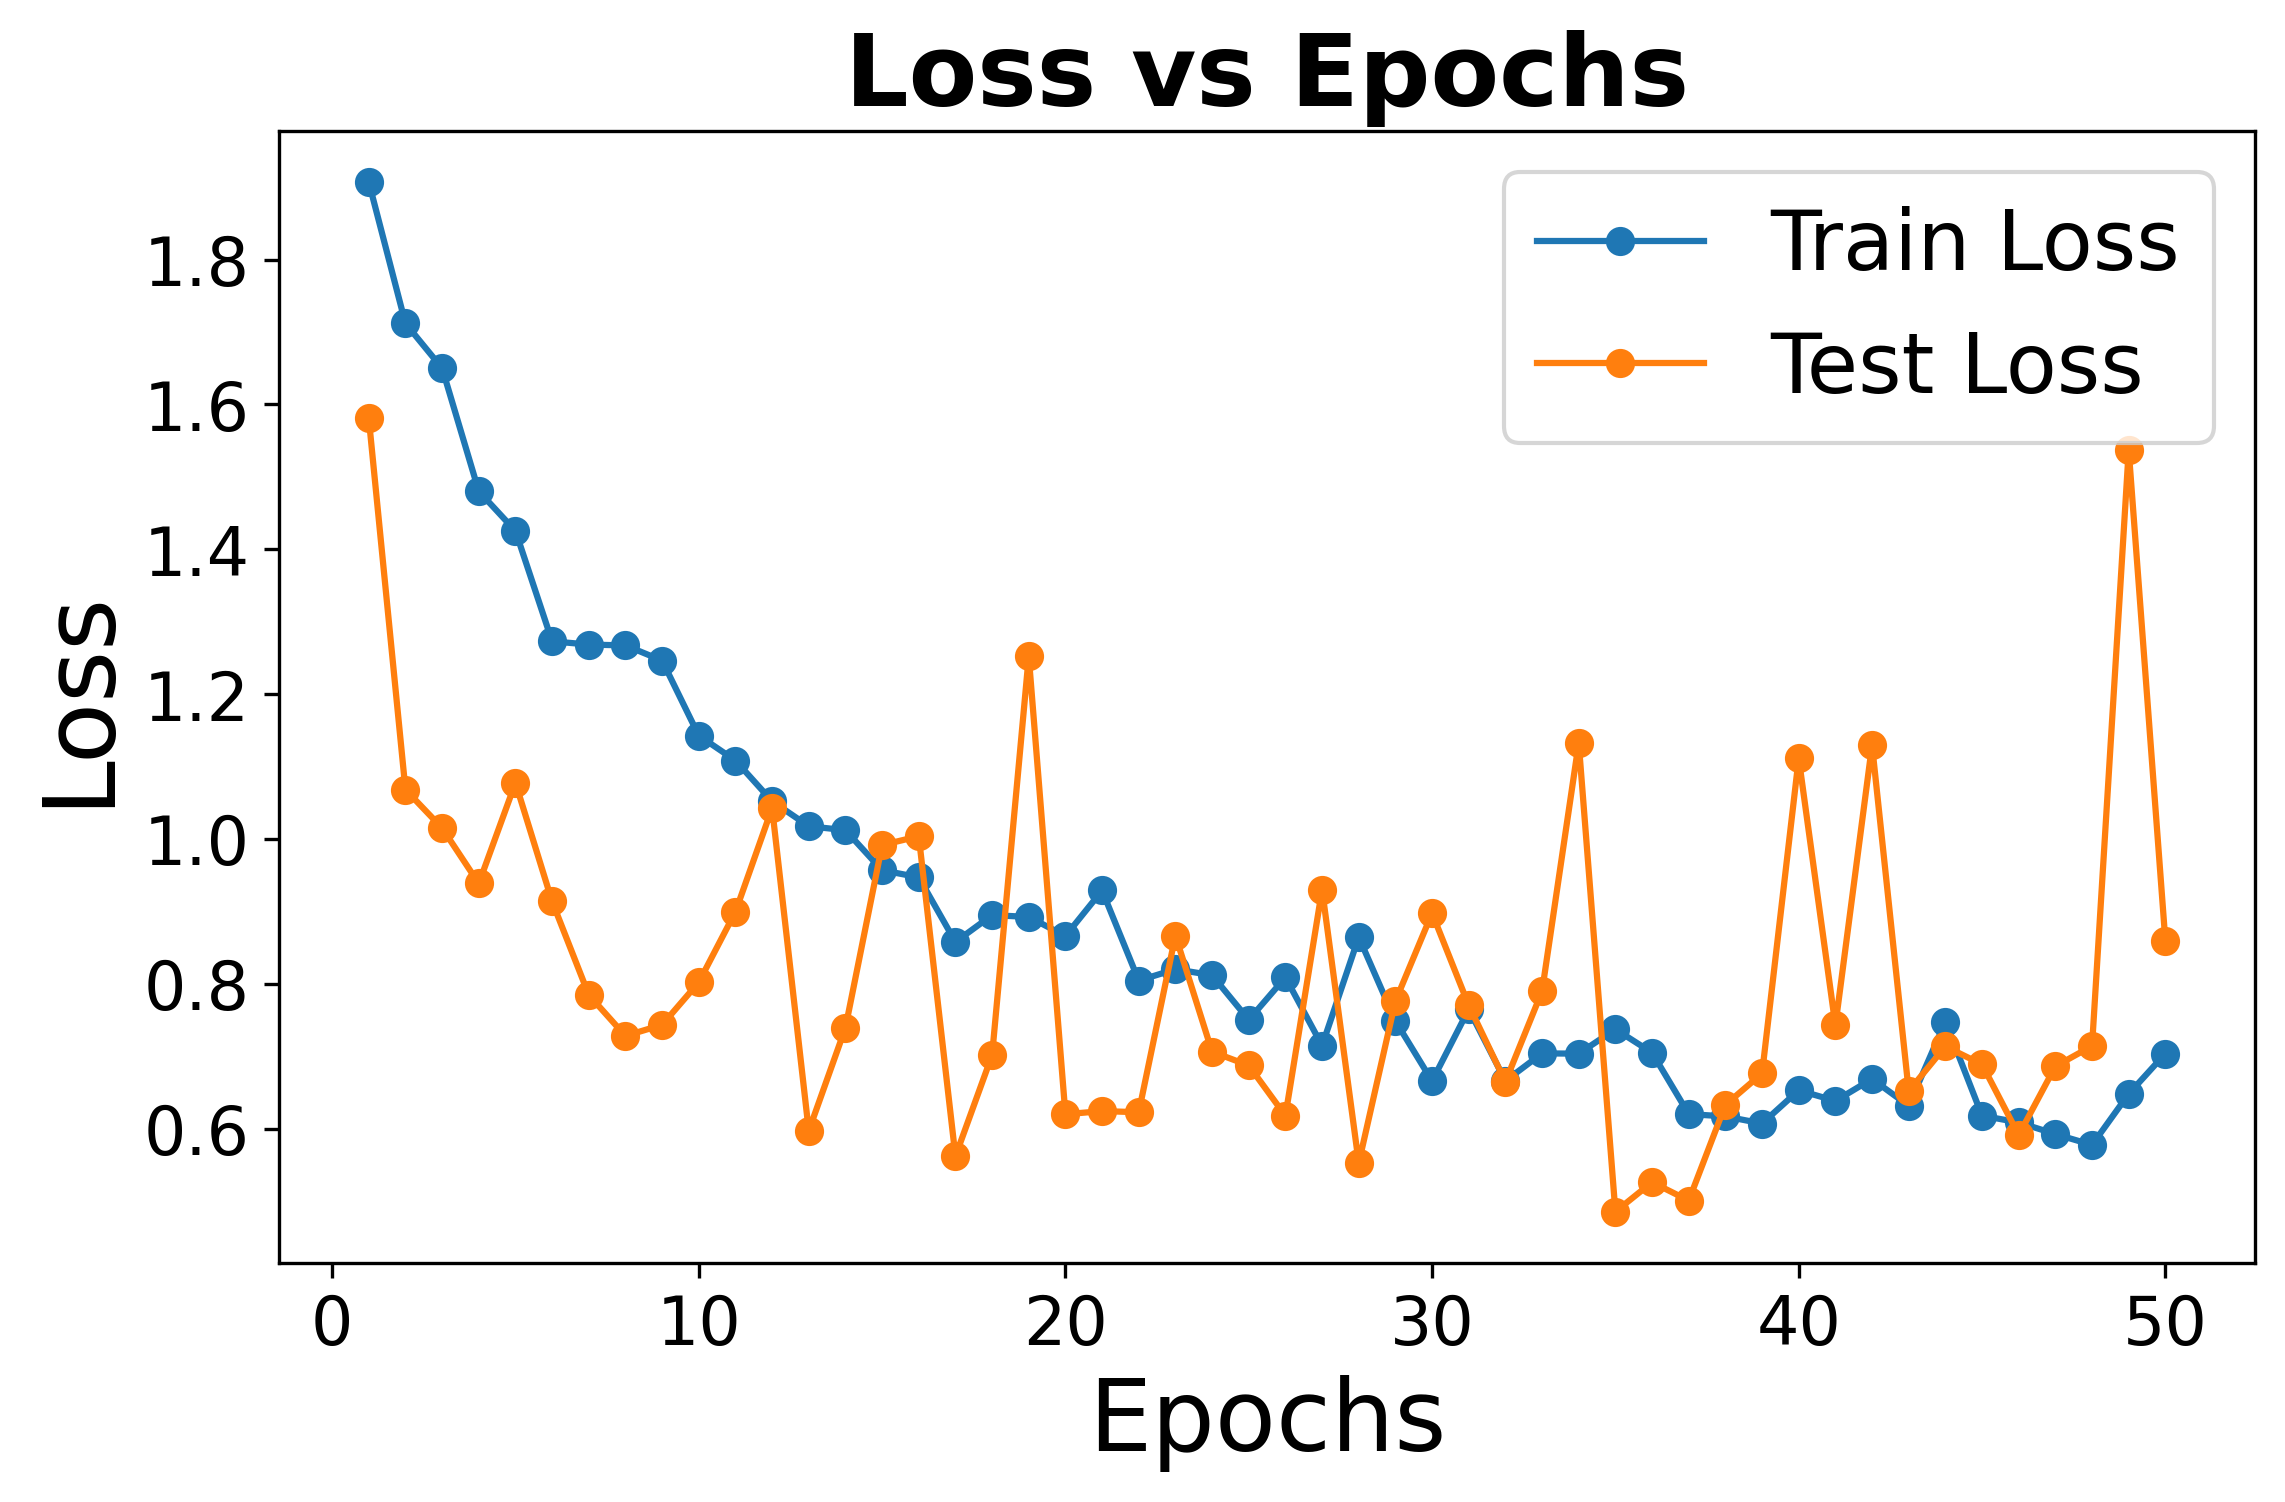

In [7]:
import seaborn as sns

from matplotlib import RcParams


myrcparams = RcParams({'axes.axisbelow': True,
          'axes.edgecolor': 'white',
          'axes.facecolor': '#EAEAF2',
          'axes.grid': True,
          'axes.labelcolor': '.15',
          'axes.linewidth': 0.0,
          'figure.facecolor': 'white',
          'font.family': ['serif'],
          'grid.color': 'white',
          'grid.linestyle': '--',
          'image.cmap': 'Greys',
          'legend.frameon': False,
          'legend.numpoints': 1,
          'legend.scatterpoints': 1,
          'lines.solid_capstyle': 'round',
          'text.color': '.15',
          'xtick.color': '.15',
          'xtick.direction': 'out',
          'xtick.major.size': 0.0,
          'xtick.minor.size': 0.0,
          'ytick.color': '.15',
          'ytick.direction': 'out',
          'ytick.major.size': 0.0,
          'ytick.minor.size': 0.0})

plt.style.library['seaborn-whitegrid']
RcParams.update(myrcparams)


fig, ax = plt.subplots(figsize =(8.5,5), dpi=300)

x = np.arange(1,len(train_loss)+1)

ax.plot(x, train_loss, '-o', label = "Train Loss", linewidth = 1.5)
ax.plot(x, test_loss, '-o', label = "Test Loss", linewidth = 1.5)

ax.set_xlabel("Epochs", fontsize = 24)
ax.set_ylabel("Loss", fontsize = 24)

ax.tick_params(
    axis = 'both',
    labelsize = 16
)
ax.legend(fontsize = 20)
ax.set_title("Loss vs Epochs", fontsize = 24, fontweight = 'bold')

plt.savefig("Loss vs Epochs.jpg", dpi = 300, bbox_inches = 'tight')
plt.savefig("Loss vs Epochs.pdf", dpi = 300, bbox_inches = 'tight')
plt.show()


In [8]:
idx_to_class = inv_map = {v: k for k, v in val.class_to_idx.items()}

correct = []
pred = []
model.eval()

with torch.no_grad():
    for batch_idx, (data,target) in enumerate(val_loader):
        # if cuda:
        #   data, target = data.cuda(), target.cuda()
        
        out = model(data)


        for _,i in enumerate(out):

            pred.append(torch.argmax(i).cpu().item())
            correct.append(target[_].cpu().item())

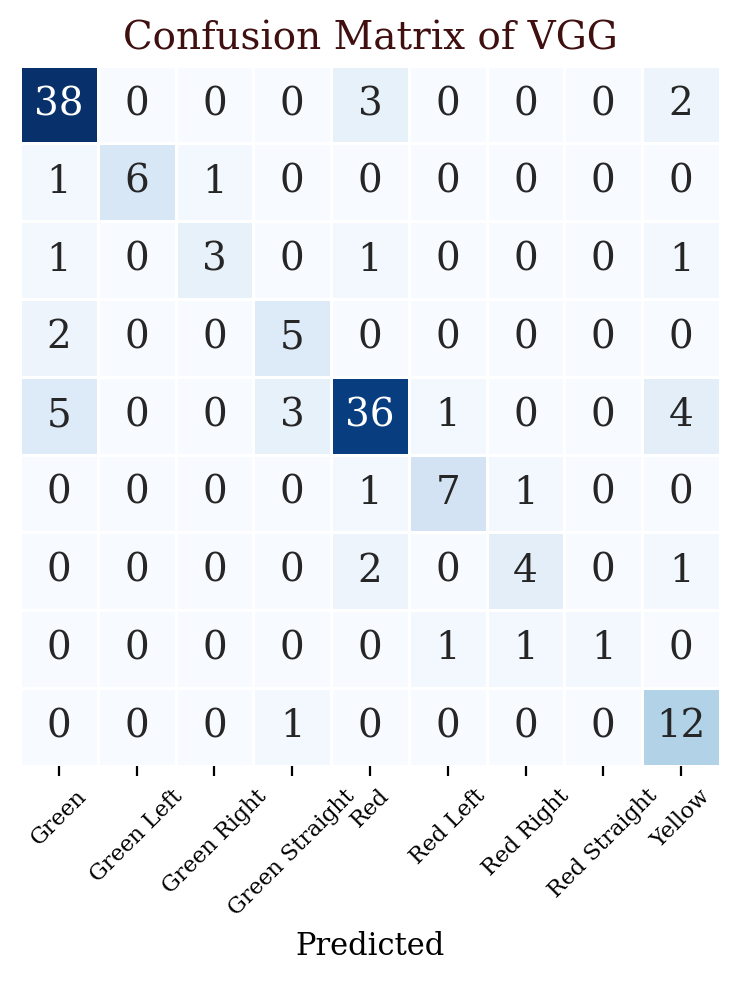

In [9]:
from sklearn.metrics import confusion_matrix

conf = confusion_matrix(correct,pred)

plt.figure(figsize=(5,5),dpi=200)

sns.heatmap(conf,cmap='Blues',cbar=False,annot=True,
            xticklabels=['Green','Green Left','Green Right','Green Straight','Red','Red Left','Red Right','Red Straight','Yellow'],
            # xticks = dict(family = 'Georgia'),
            yticklabels=[' ']*9,
            linewidths=0.5,
            annot_kws={'size':14,
                       'weight':'normal',
                       'family':'Serif'})
# ax=plt.gca()
# ax.get_yaxis().set_visible(False)
plt.xlabel('Predicted', fontsize = 11,font = dict(family = 'Serif')) # x-axis label with fontsize 15
plt.xticks(rotation=45,font=dict(family='Serif',size = 8))
plt.yticks([])
plt.title("Confusion Matrix of VGG",fontsize=14,family='Serif',color='#401010',fontweight=10)
plt.subplots_adjust(left=0.25, right=0.95, top=0.9, bottom=0.2)
# plt.savefig('Group4/Lab7/VGG_CM.jpg')
plt.show()

In [10]:
test_loader = torch.utils.data.DataLoader(
    val, 
    batch_size= 1,
    shuffle=True
)

In [12]:

categories = [0,1,2,3,4,5,6,7,8]


top1 = 0
top5 = 0
with torch.no_grad():
    for batch_idx, (data,target) in enumerate(test_loader):
        # if cuda:
        #   data, target = data.cuda(), target.cuda()
        out = model(data)
        probabilities = torch.nn.functional.softmax(out[0], dim=0)
        top1_prob, top1_catid = torch.topk(probabilities, 1)
        prob_1 = []
        for i in range(top1_prob.size(0)):
            prob_1.append(categories[top1_catid[i]])
        if target[_].cpu().item() in prob_1:
            top1+=1
        top5_prob, top5_catid = torch.topk(probabilities, 5)
        prob_5 = []
        for i in range(top5_prob.size(0)):
            prob_5.append(categories[top5_catid[i]])
        if target[_].cpu().item() in prob_5:
            top5+=1
    print(top1/145,top5/145)

0.7724137931034483 0.9724137931034482
